In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
print('导入成功')
pd.set_option('display.max_columns',200)
pd.set_option('max_row',200)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

导入成功


In [2]:
# #身份证编码规则：
# 1、新版中国的居民身份证有18位；
# 2、其中前17位是信息码，最后1位是校验码；
# 3、每位信息码可以是0-9的数字，而校验码可以是0-9或X，其中X表示10；
# 4、第17位数字代表“性别”，奇数为“男”，偶数为“女”；
# 5、第1-2位数字表示“所在地身份（或自治区、直辖市）”；
# 6、第3-4位数字表示“所在地的市（或州）”；
# 7、第5-6位数字表示“所在地的县（或县级市）”；
# 8、最后4位的前两位表示“当地派出所的编号”；
# 9、排列顺序从左至右依次为:六位数字地址码，八位数字出生日期码，三位数字顺序码和一位数字校验码。
# 10、身份证第18位（校验码）的计算方法：
# （a）设18位身份证号序列从左到右为: 
# a[0], a[1], a[2], a[3], ..., a[16], a[17]其中a[i]表示第i位数字，i=0,1,2,...,17，（如果最后一位（校验位）是X，则a[17]=10）
# (b)每一位被赋予一个“权值”，其中，第i位的权值w[i]的计算方法是： 
# w[i] = 2**(17-i) % 11，其中，i=0,1,2,3,...,17，运算符按Python惯例：x**y表示x的y次方，x%y表示x除以y的余数。
# 最终得到从第一位到第十七位的权重系数分别为：[7, 9, 10, 5, 8, 4, 2, 1, 6, 3, 7, 9, 10, 5, 8, 4, 2]
# (c)将这17位数字和系数相乘的结果相加,用加出来和除以11，看余数是多少？
# 即：(a[0]*w[0] + a[1]*w[1] + a[2]*w[2] + ... + a[16]*w[16]) % 11 
# （d）余数只可能有0－1－2－3－4－5－6－7－8－9－10这11个数字,
# 其分别对应的最后一位身份证的号码为1－0－X－9－8－7－6－5－4－3－2。

In [3]:
df=pd.read_excel(r'D:\000-mine\richang2019\临时\0719\订单明细.xlsx',sep='\t',index_col=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217589 entries, 0 to 217588
Data columns (total 95 columns):
订单编号           217589 non-null object
原始订单           217589 non-null object
订单类型           217589 non-null object
订单状态           217589 non-null object
订单子状态          69050 non-null object
取消原因           4 non-null object
订单挂起原因         3834 non-null object
安装失败原因         0 non-null float64
订单来源           217589 non-null object
结算状态           0 non-null float64
支付平台           217589 non-null object
机价款            0 non-null float64
店铺             217589 non-null object
AB类型           217589 non-null object
拆单类型           217589 non-null object
制式类型           217589 non-null object
订单金额           217589 non-null float64
支付方式           217589 non-null object
支付流水号          2930 non-null object
收取卡密号码         0 non-null float64
订单生成时间         217589 non-null object
支付完成时间         2995 non-null object
交易完成时间         119861 non-null object
发货时间           163250 non-null object
物流单回

In [4]:
sf_df=pd.DataFrame(df,index=df.index,columns=['订单编号','订单状态','订单生成时间','物流单号',
                                              '交易完成时间','入网用户姓名','入网身份证号','入网手机号',
                                             '收货人姓名','所在省 / 市 / 县','号码归属地','销售品编号',
                                             '销售品名称'])
#“所在省 / 市 / 县”——配送地址，‘号码归属地’——手机卡归属地,"入网身份证号"——籍贯的省市，“收货电话”——号码归属省，
#4个地址一致性：超三个为高风险用户。
# print(sf_df[sf_df['入网身份证号'].isnull()])   #校验“入网身份证号”为空的行数据

In [5]:
sf_df.dropna(subset=['入网身份证号'],inplace=True)  #删除“入网身份证号”为空的行数据
sf_df.reset_index(drop=True,inplace=True)   #重置索引，并删除原来的索引

In [6]:
# 方法一：使用for循环可以实现将“奇偶数”表示的性别转为“男女”格式，但是时间复杂度太高
# # sf_df['性别']=sf_df['入网身份证号'].str.slice(16,17)
# # for i in range(len(sf_df['性别'])):
# #     if int(sf_df.loc[i,['性别']]) % 2==0:
# #         sf_df.loc[i,['性别']]="女"
# #     else:
# #         sf_df.loc[i,['性别']]="男"
# 方法二：先将“奇偶数”表示的性别列取出，后将object类型数据转为数值型，再直接调用函数，速度很快
# help(df.infer_objects)  #该命令可调出关于将object类型数据转为何种数据类型的语法帮助

In [7]:
#根据“订单生成时间”到“交易完成时间”之差即：“交易周期”列
#Dataframe中的时间是不能直接进行相加减的,所以需要先用pandas的to_datetime()方法，转化成时间格式进行加减，然后再转换成df格式
#delta=df1['Time_end']-df1['Time_start'] #直接报错TypeError: unsupported operand type(s) for -: 'str' and 'str'
#日期相减变为小时；变为天的话将h替换为D即可：
sf_df['交易周期']=pd.DataFrame((pd.to_datetime(sf_df['交易完成时间'])-
                            pd.to_datetime(sf_df['订单生成时间'])).values/np.timedelta64(1,'h'))
print(sf_df['交易周期'].tail())

215732    0.10
215733     nan
215734     nan
215735   27.93
215736    9.65
Name: 交易周期, dtype: float64


In [8]:
sf_df['性别']=sf_df['入网身份证号'].str.slice(16,17)
sf_df['性别'] = pd.to_numeric(sf_df['性别'])   #这个函数是将object转为数值型
def get_sex(str1):
    #查看性别
    if str1 % 2 ==0:
        return '女'
    else:
        return '男'

sf_df['性别'] =  sf_df['性别'].apply(get_sex)
# print(sf_df.info())

In [9]:
#对用户根据年龄段进行分类
sf_df['年龄'] =sf_df['入网身份证号'].str.slice(6,10)   #从“入网身份证号”中提取“年龄信息”
sf_df['年龄']=pd.to_numeric(sf_df['年龄'])  ##这个函数是将object转为数值型
# print(sf_df.loc[:10,['年龄分级']])
now_year=pd.datetime.now().year  #获取当前的年份
# print("当前时间是:",now_year)
sf_df['年龄']=now_year-sf_df['年龄']  #当前年份-出生年龄得到，年龄分级
# print(sf_df.loc[:10,['年龄分级']])
def get_year_group(str1):  #定义年龄分级函数
    if str1 <= 18:
        return "少年"
    elif str1 < 30:
        return "弱冠"
    elif str1 < 40:
        return "而立"
    elif str1 < 50:
        return "不惑"
    elif str1 < 60:
        return "知命"
    elif str1 < 70:
        return "花甲"
    else:
        return "老年"

sf_df['年龄分级']=sf_df['年龄'].apply(get_year_group)  #调用年龄分级函数，用df[col_name].apply(function_name)
#将'号码归属地'的列拆分为“号码归属省”和“号码归属市”两列   #即分析用户的地域特征
# sf_df[['所在省 / 市 / 县','号码归属地']].head(100)   
# df=sf_df['号码归属地'].str.split('/')  #该种方法也可实现，不过时间复杂度较高
df_add=pd.DataFrame((x.split('/') for x in sf_df['号码归属地']),
                    index=sf_df.index,columns=['号码归属省','号码归属市'])
# print(df_add.tail())
sf_df=sf_df.join(df_add)
sf_df.drop(['号码归属地'],axis=1,inplace=True)

In [10]:
# "发货量"为“物流单号”不为空的订单，“激活量”为“订单状态”为“交易完成”的订单
# sf_df['物流单号'].astype(str).dtype   #此种方法将object类型转为str类型失效
sf_df_fahuo=sf_df[sf_df['物流单号'].notnull()]   #筛选出“物流单号”不为空的行数据即：“发货量”
print(sf_df_fahuo.info())
#新增“激活与否”列，根据“订单状态”为“交易完成”的为“已激活订单”赋值为1，“未激活订单”赋值为0；
sf_df_fahuo['激活与否']=None
def jh_decide(str1):
    if(str1=="交易完成"):
        return 1
    else:
        return 0
    
sf_df_fahuo['激活与否']=sf_df_fahuo['订单状态'].apply(jh_decide)
# print(sf_df_fahuo.loc[:100,['订单状态','激活与否']])   #验证新增列“激活与否”与“订单状态”对应

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162756 entries, 2 to 215736
Data columns (total 18 columns):
订单编号           162756 non-null object
订单状态           162756 non-null object
订单生成时间         162756 non-null object
物流单号           162756 non-null object
交易完成时间         119433 non-null object
入网用户姓名         162756 non-null object
入网身份证号         162756 non-null object
入网手机号          162756 non-null int64
收货人姓名          162756 non-null object
所在省 / 市 / 县    162756 non-null object
销售品编号          162756 non-null int64
销售品名称          162756 non-null object
交易周期           119433 non-null float64
性别             162756 non-null object
年龄             162756 non-null int64
年龄分级           162756 non-null object
号码归属省          162756 non-null object
号码归属市          162756 non-null object
dtypes: float64(1), int64(3), object(14)
memory usage: 23.6+ MB
None


c:\users\evan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\evan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [11]:
#匹配产品标卡
biaoka=pd.read_excel(r'D:\000-mine\richang2019\原始数据集\产品标卡0709.xlsx',sep='\t',index_col=None)
biaoka.drop_duplicates(subset=['销售品编号'],keep='last',inplace=True)  #去重
biaoka.drop(['销售品名称'],axis=1,inplace=True)
sf_df_fahuo=pd.merge(sf_df_fahuo,biaoka,how='left',on='销售品编号')
print(biaoka.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 34 to 706
Data columns (total 2 columns):
销售品编号    668 non-null int64
产品分类     668 non-null object
dtypes: int64(1), object(1)
memory usage: 15.7+ KB
None


In [12]:
# print(sf_df_fahuo.info())

In [13]:
#part01 分析“激活与否”与“性别”、“年龄分级”、“产品分类”、“号码归属省”、“交易周期”各特征变量的关系
#特征相关性分析，spearman用于离散型变量
print(sf_df_fahuo['激活与否'].corr(sf_df_fahuo['性别'],method='spearman'))  #两列之间的相关度计算
print(sf_df_fahuo['激活与否'].corr(sf_df_fahuo['年龄分级'],method='spearman')) 
print(sf_df_fahuo['激活与否'].corr(sf_df_fahuo['号码归属省'],method='spearman')) 
print(sf_df_fahuo['激活与否'].corr(sf_df_fahuo['产品分类'],method='spearman'))
print(sf_df_fahuo['激活与否'].corr(sf_df_fahuo['交易周期'],method='spearman'))
print("="*50)
print(sf_df_fahuo['产品分类'].corr(sf_df_fahuo['性别'],method='spearman'))
print(sf_df_fahuo['产品分类'].corr(sf_df_fahuo['年龄分级'],method='spearman'))
print(sf_df_fahuo['产品分类'].corr(sf_df_fahuo['号码归属省'],method='spearman'))
print(sf_df_fahuo['产品分类'].corr(sf_df_fahuo['交易周期'],method='spearman'))

c:\users\evan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


-0.07506799907748103
0.13565676413724592
0.0029258613799464737
-0.14785852579925973
-0.004775989850378669
0.13259535769556047
-0.17013142844828066
-0.008068636413560124
0.6001361002699821


In [14]:
#原始数据的可视化分析
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'  #在屏幕上显示高清图片
%matplotlib inline
import matplotlib as mpl            #解决中文不识别的问题
import matplotlib.ticker as ticker
mpl.rcParams['font.sans-serif']=['KaiTi']  
mpl.rcParams['font.serif']=['KaiTi']
mpl.rcParams['axes.unicode_minus']=False  # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串

In [15]:
sf_df_fahuo['激活与否'].value_counts()

1    119427
0     43329
Name: 激活与否, dtype: int64

Text(0.5, 1.0, '激活与否的分布百分比')

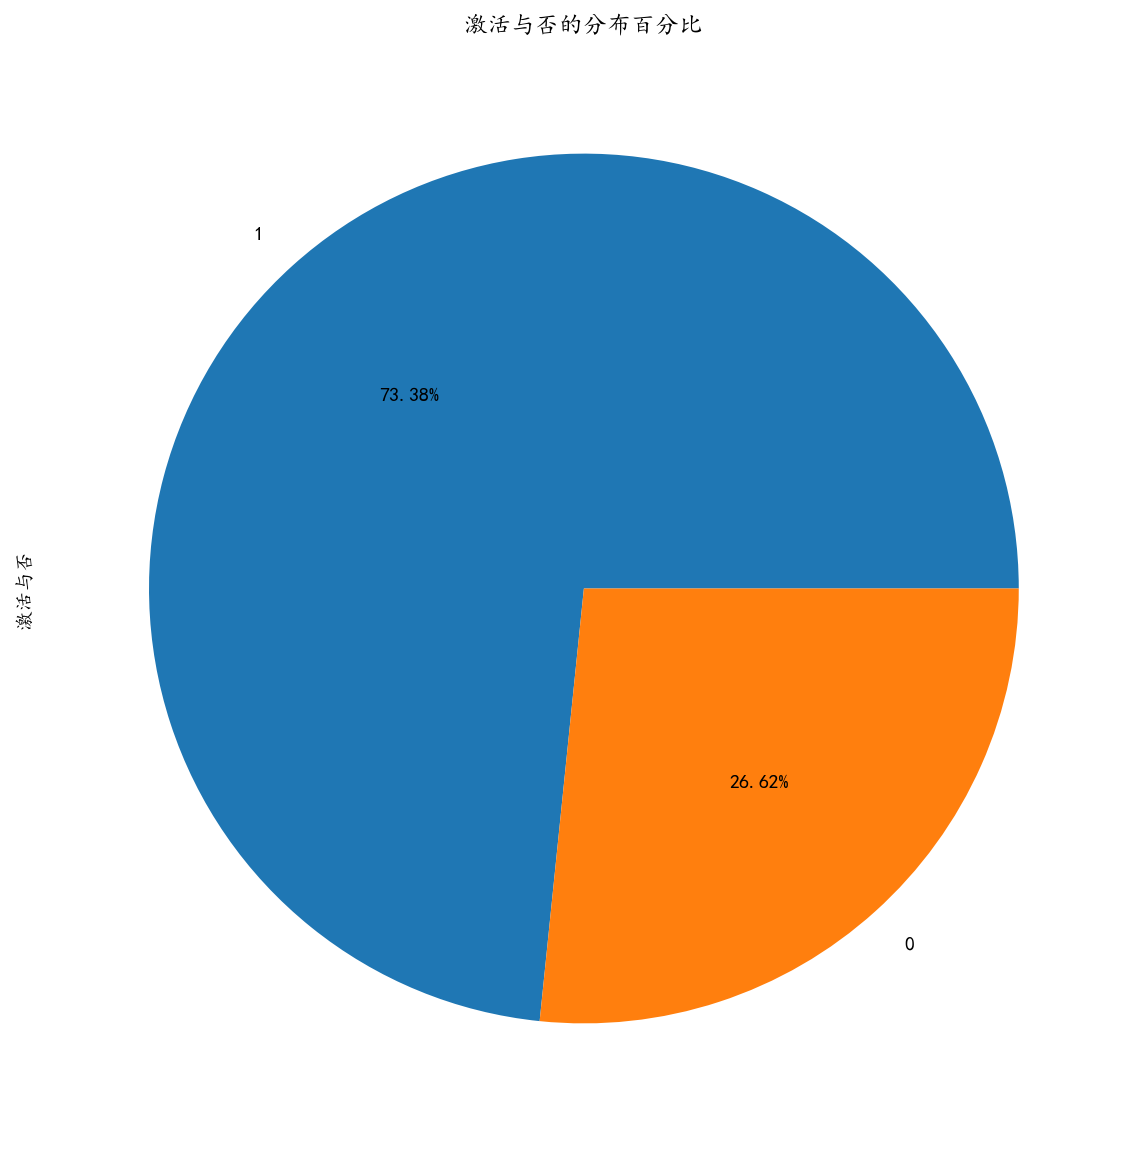

In [16]:
#订单的“激活与否”的总体分布情况——“1”表示“激活”，“0”表示“未激活”
f,ax=plt.subplots(1,1,figsize=(10,10))
sf_df_fahuo['激活与否'].value_counts().plot.pie(autopct='%1.2f%%')
ax.set_title("激活与否的分布百分比")
# ax.set_xlabel('号码归属省',fontsize=20,color='r')   #设置X轴标签的“名称”、字体大小和字体颜色
# ax.set_ylabel('订单量',fontsize=20,color='r')    #设置Y轴标签的“名称”、字体大小和字体颜色

count   162756.00
mean        34.76
std         15.87
min         15.00
25%         22.00
50%         30.00
75%         45.00
max         96.00
Name: 年龄, dtype: float64


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

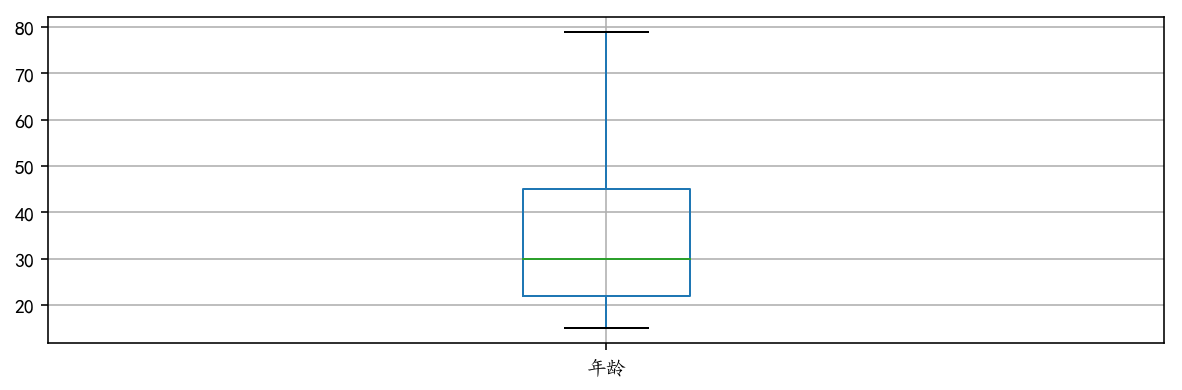

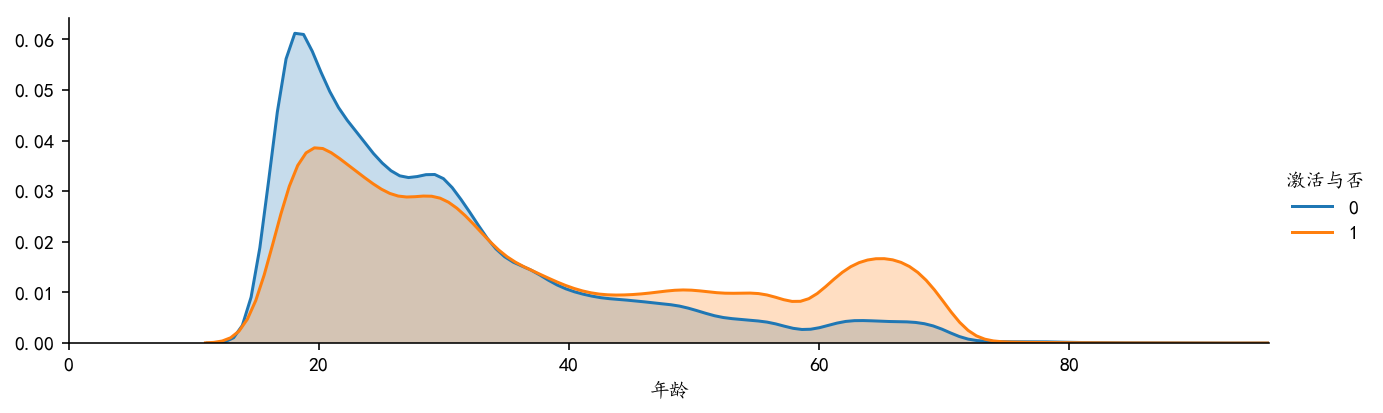

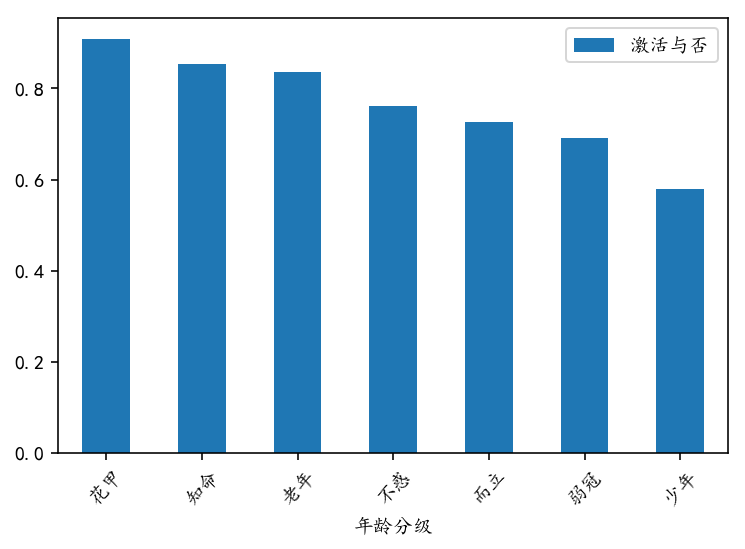

In [17]:
#不同年龄段的分布情况
print(sf_df_fahuo['年龄'].describe()) 
#分析总体的年龄分布
plt.figure(figsize=(10,3))
# plt.subplot(121)
sf_df_fahuo.boxplot(column='年龄',showfliers=False)   #用户年龄分布的“箱线图”，均值为30岁，
# plt.subplot(122)
facet=sns.FacetGrid(sf_df_fahuo,hue="激活与否",aspect=3)  #先sns.FacetGrid画出轮廓
facet.map(sns.kdeplot,'年龄',shade=True)   #然后用map填充内容，此处为kdeplot(核密度估计图)，

# 通过核密度估计图可以比较直观的看出数据样本本身的分布特征   #分析可知男、女的“激活与否”的“年龄”密度分布基本一致
facet.set(xlim=(0,sf_df_fahuo['年龄'].max()))
facet.add_legend()   #图例legend设置，legend语法参数如下: matplotlib.pyplot.legend(*args, **kwargs)

#"年龄分级"与“激活与否”的关系的条形图
nj_jh=sf_df_fahuo[['年龄分级','激活与否']].groupby(['年龄分级'],as_index=False).mean()
nj_jh.set_index('年龄分级',inplace=True)
nj_jh.sort_values("激活与否",ascending=False).plot.bar()  #观察可知：年龄越大，人越趋于理性，激活率越高
import pylab as pl
pl.xticks(rotation=45)    #matplotlib画图，x轴标签旋转45度
# nj_jh.set_title("年龄分级与激活与否的分布关系")  #该方法失效

         订单量
产品分类        
V粉卡     8583
京东权益卡  56223
京粉卡     7517
农行金翼      10
大王卡      242
大黑牛卡      99
头条卡       10
抖音卡     7720
斗鱼卡       19
新装      3194
百度圣卡   28411
米粉卡体验  39833
米粉卡日租    714
网易白金卡   2012
翼视卡       56
芒果卡      116
连尚万能卡    245
阿里鱼卡    7737
       激活率
产品分类      
V粉卡   0.55
京东权益卡 0.89
京粉卡   0.69
农行金翼  0.60
大王卡   0.82
大黑牛卡  0.71
天翼云卡  1.00
头条卡   0.90
好声音   1.00
抖音卡   0.70
斗鱼卡   0.89
新装    0.92
百度圣卡  0.54
米粉卡体验 0.69
米粉卡日租 0.83
网易白金卡 0.73
翼视卡   0.68
芒果卡   0.58
苏宁嗨卡  0.75
连尚万能卡 0.65
阿里鱼卡  0.67


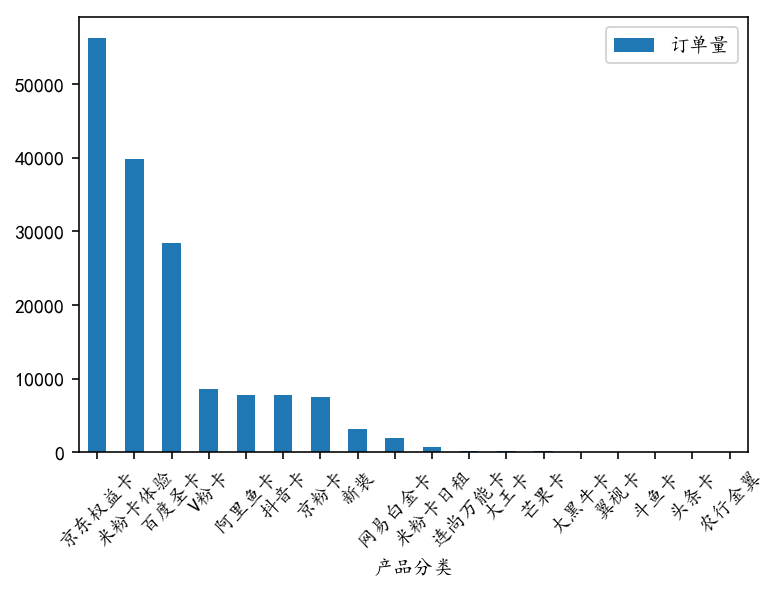

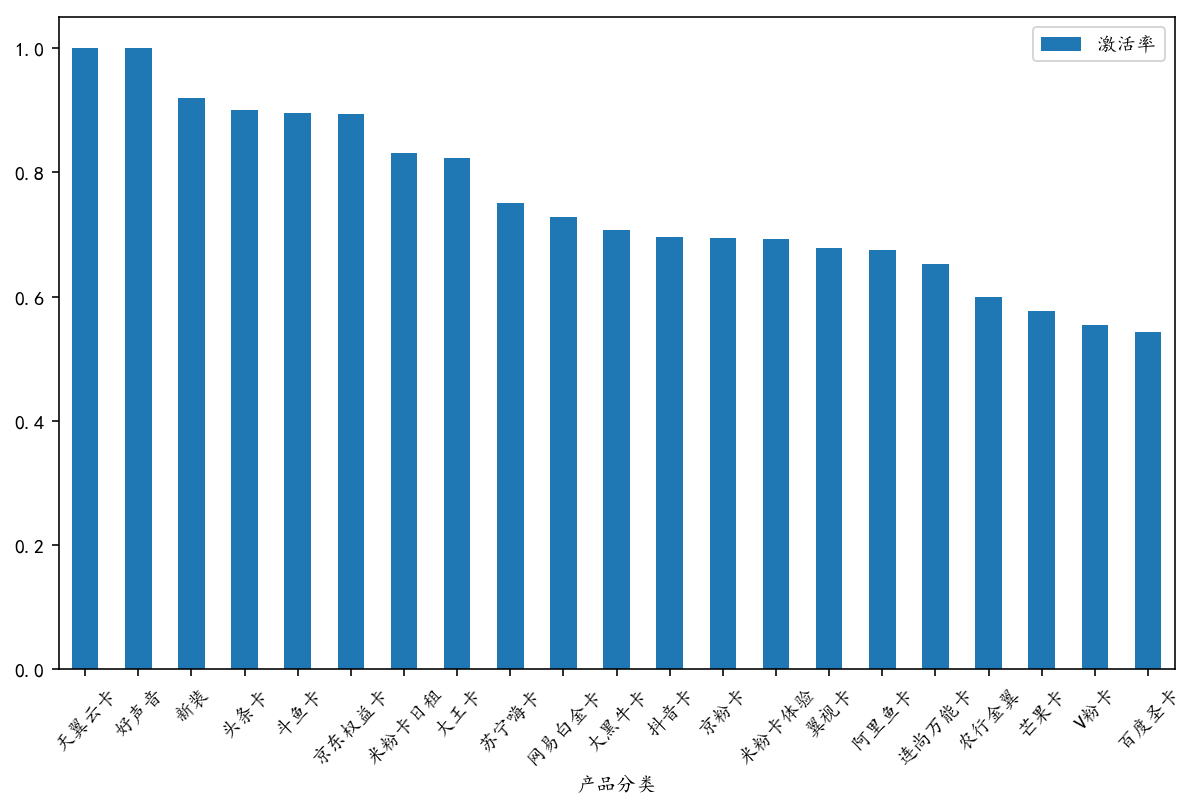

In [18]:
#分析“产品分类”与“激活与否”的分布关系，图为“产品分类”按“激活率”大小降序排列
cp_jh_ys_c=sf_df_fahuo[['产品分类','激活与否']].groupby(['产品分类'],as_index=False).count()   #统计订单量
cp_jh_ys_c=cp_jh_ys_c[cp_jh_ys_c['激活与否']>9]  #筛选“订单量”大于9单的卡品
cp_jh_ys_c.set_index('产品分类',inplace=True)
cp_jh_ys_c.rename(columns={'激活与否':'订单量'},inplace=True)
print(cp_jh_ys_c)  #查看筛选后的数据
cp_jh_ys_c.sort_values('订单量',ascending=False).plot.bar()
pl.xticks(rotation=45)
plt.rcParams['figure.figsize'] = (10.0, 6.0) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest'
# #总体"产品分类"与“激活与否”的关系
# cp_jh_ys=sf_df_fahuo[['产品分类','激活与否']].groupby(['产品分类'],as_index=False).agg(['mean', 'count']) #引出复合索引不好处理
cp_jh_ys_m=sf_df_fahuo[['产品分类','激活与否']].groupby(['产品分类'],as_index=False).mean()   #统计激活率
cp_jh_ys_m.set_index('产品分类',inplace=True)
cp_jh_ys_m.rename(columns={'激活与否':'激活率'},inplace=True)
print(cp_jh_ys_m)  #查看筛选后的数据
cp_jh_ys_m.sort_values('激活率',ascending=False).plot.bar()
pl.xticks(rotation=45)    #matplotlib画图，x轴标签旋转45度
plt.rcParams['figure.figsize'] = (10.0, 6.0) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest'

In [19]:
#分析“交易周期”与“激活与否”的关系
sf_df_fahuo_jy=sf_df_fahuo[sf_df_fahuo['交易周期']<1000]  #“交易周期”大于1000小时的极个别订单过滤掉
print(sf_df_fahuo_jy.describe())

               入网手机号           销售品编号      交易周期        年龄      激活与否
count      119432.00       119432.00 119432.00 119432.00 119432.00
mean  16928429055.35  16831564512.11     37.39     36.65      1.00
std    1461013056.17  69406880197.89     59.21     16.47      0.01
min   13301939271.00  10001213410.00      0.03     16.00      0.00
25%   17303758464.25  10011227821.00      0.10     23.00      1.00
50%   17338707256.50  10011228962.00     22.50     31.00      1.00
75%   17725674594.75  10011228966.00     48.23     50.00      1.00
max   19997926495.00 903361143779.00    872.50     91.00      1.00


Text(0.5, 1.0, '性别与激活与否的分布关系')

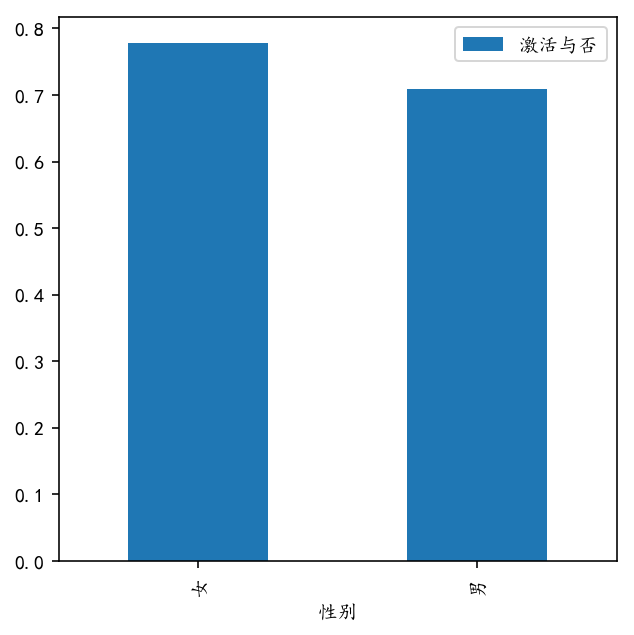

In [20]:
#总体“性别”与“激活与否”的关系
mpl.rc("figure", figsize=(5,5))   #大小设置
sf_df_fahuo[['性别','激活与否']].groupby(['性别']).mean().plot.bar()   #女性的激活率相对较高
ax.set_title("性别与激活与否的分布关系")
# train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

([<matplotlib.axis.XTick at 0x19280cabcc0>,
 <a list of 27 Text xticklabel objects>)

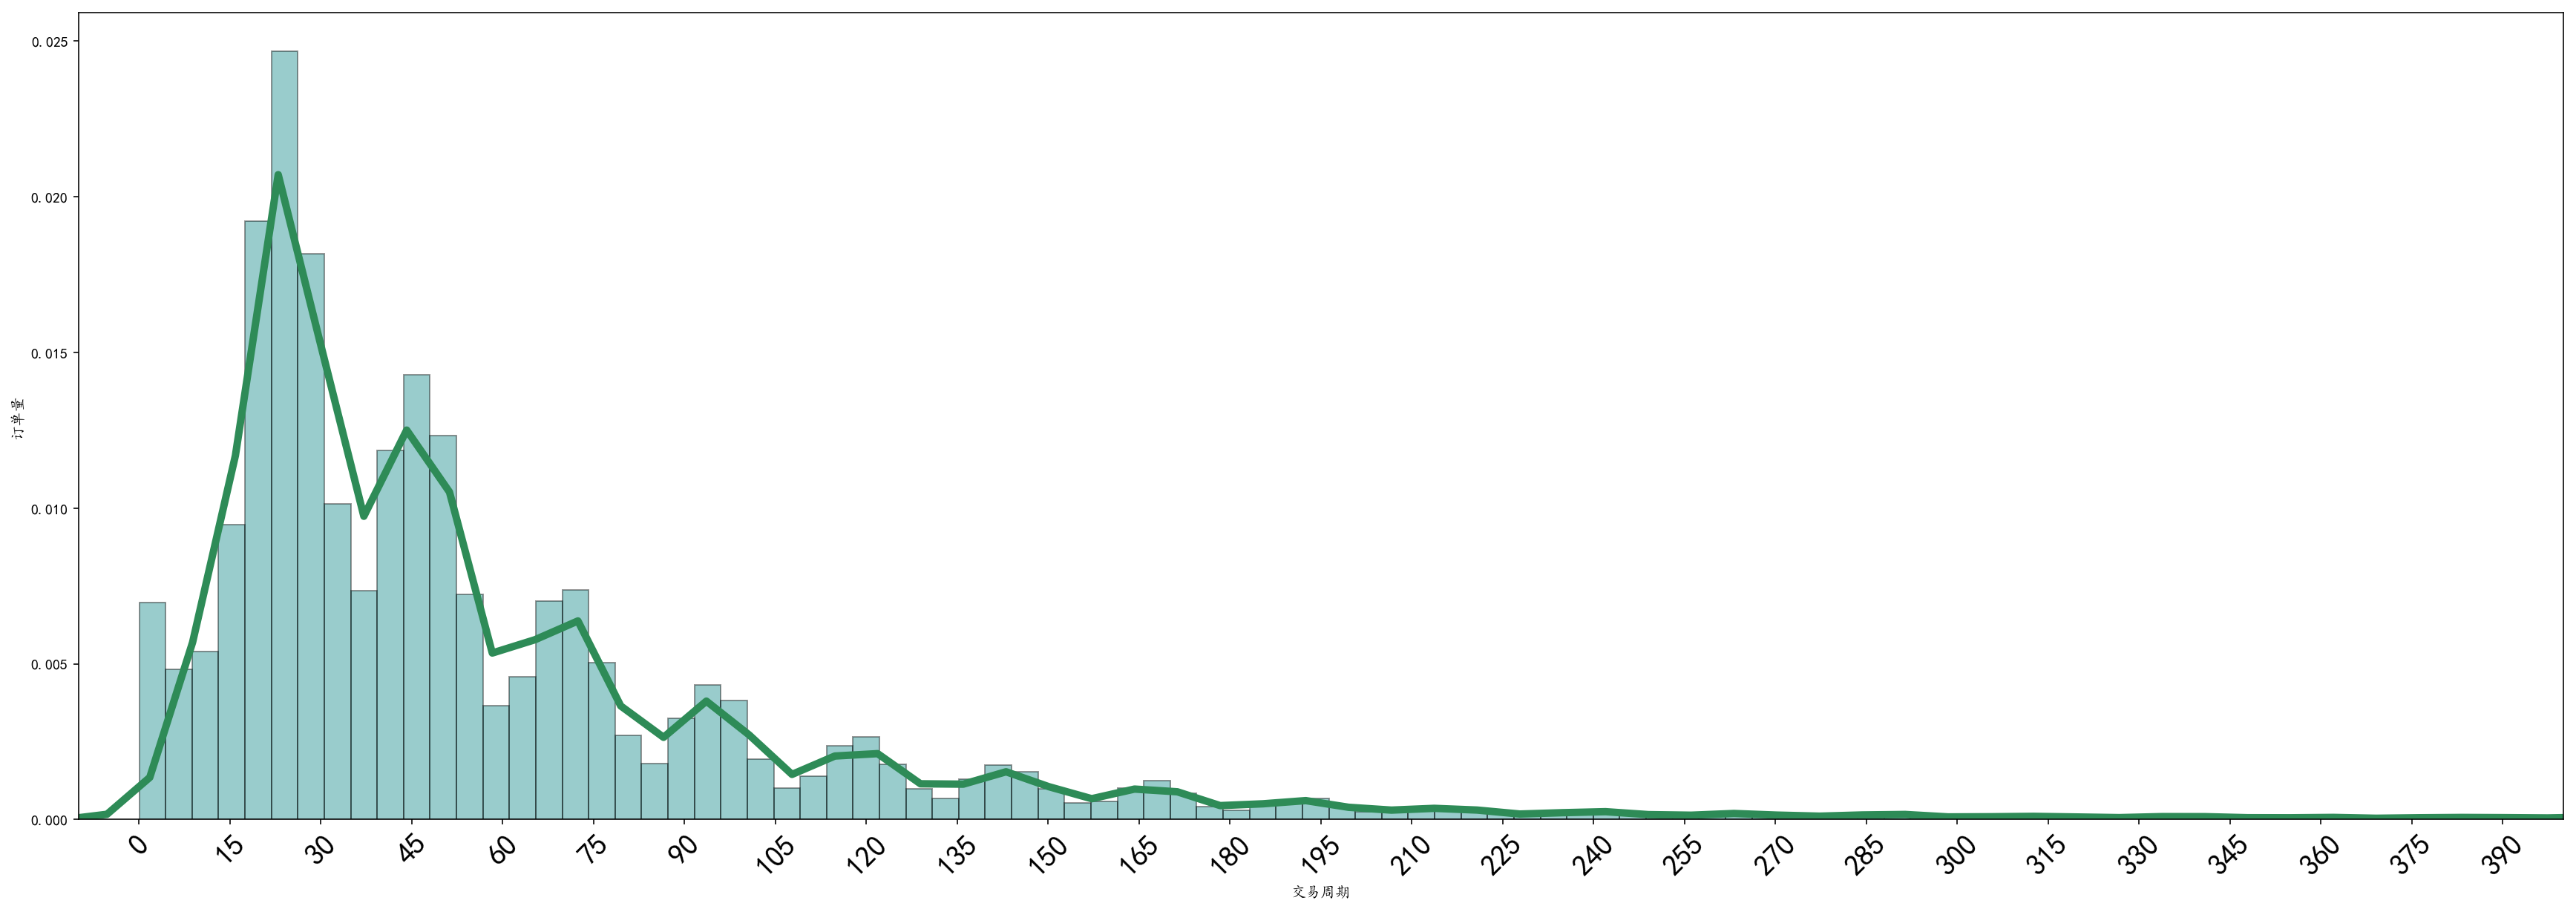

In [21]:
#"交易周期"的频率分布直方图
jy_jh=sf_df_fahuo_jy[['交易周期','激活与否']].groupby('交易周期',as_index=False).count()
#直方图与柱状图外观表现很相似，用来展现连续型数据分布特征的统计图形（柱状图主要展现离散型数据分布）
# jy_jh['交易周期'].hist(bins=200)   #无拟合曲线 
# sns.set_palette("hls") #设置所有图的颜色，使用hls色彩空间
mpl.rc("figure", figsize=(30,10))   #大小设置
sns.distplot(jy_jh['交易周期'],bins=200,kde_kws={"color":"seagreen", "lw":5 },
             hist_kws=dict(edgecolor='k',color='Teal'))  #edgecolor设置柱子边界线，color设置柱子颜色#kde_kws为拟合曲线参数
plt.xlabel('交易周期')
plt.ylabel('订单量')
plt.xlim(-10,400)#设置x轴分布范围
sns.set_context("talk", font_scale=2, rc={'line.linewidth':2.5})  # 使用talk风格，字体大小
plt.xticks(range(0,400,15),fontsize=20,rotation=45)
# plt.xticks(np.linspace(-10,400,20),fontsize=15)   #设置刻度间隔

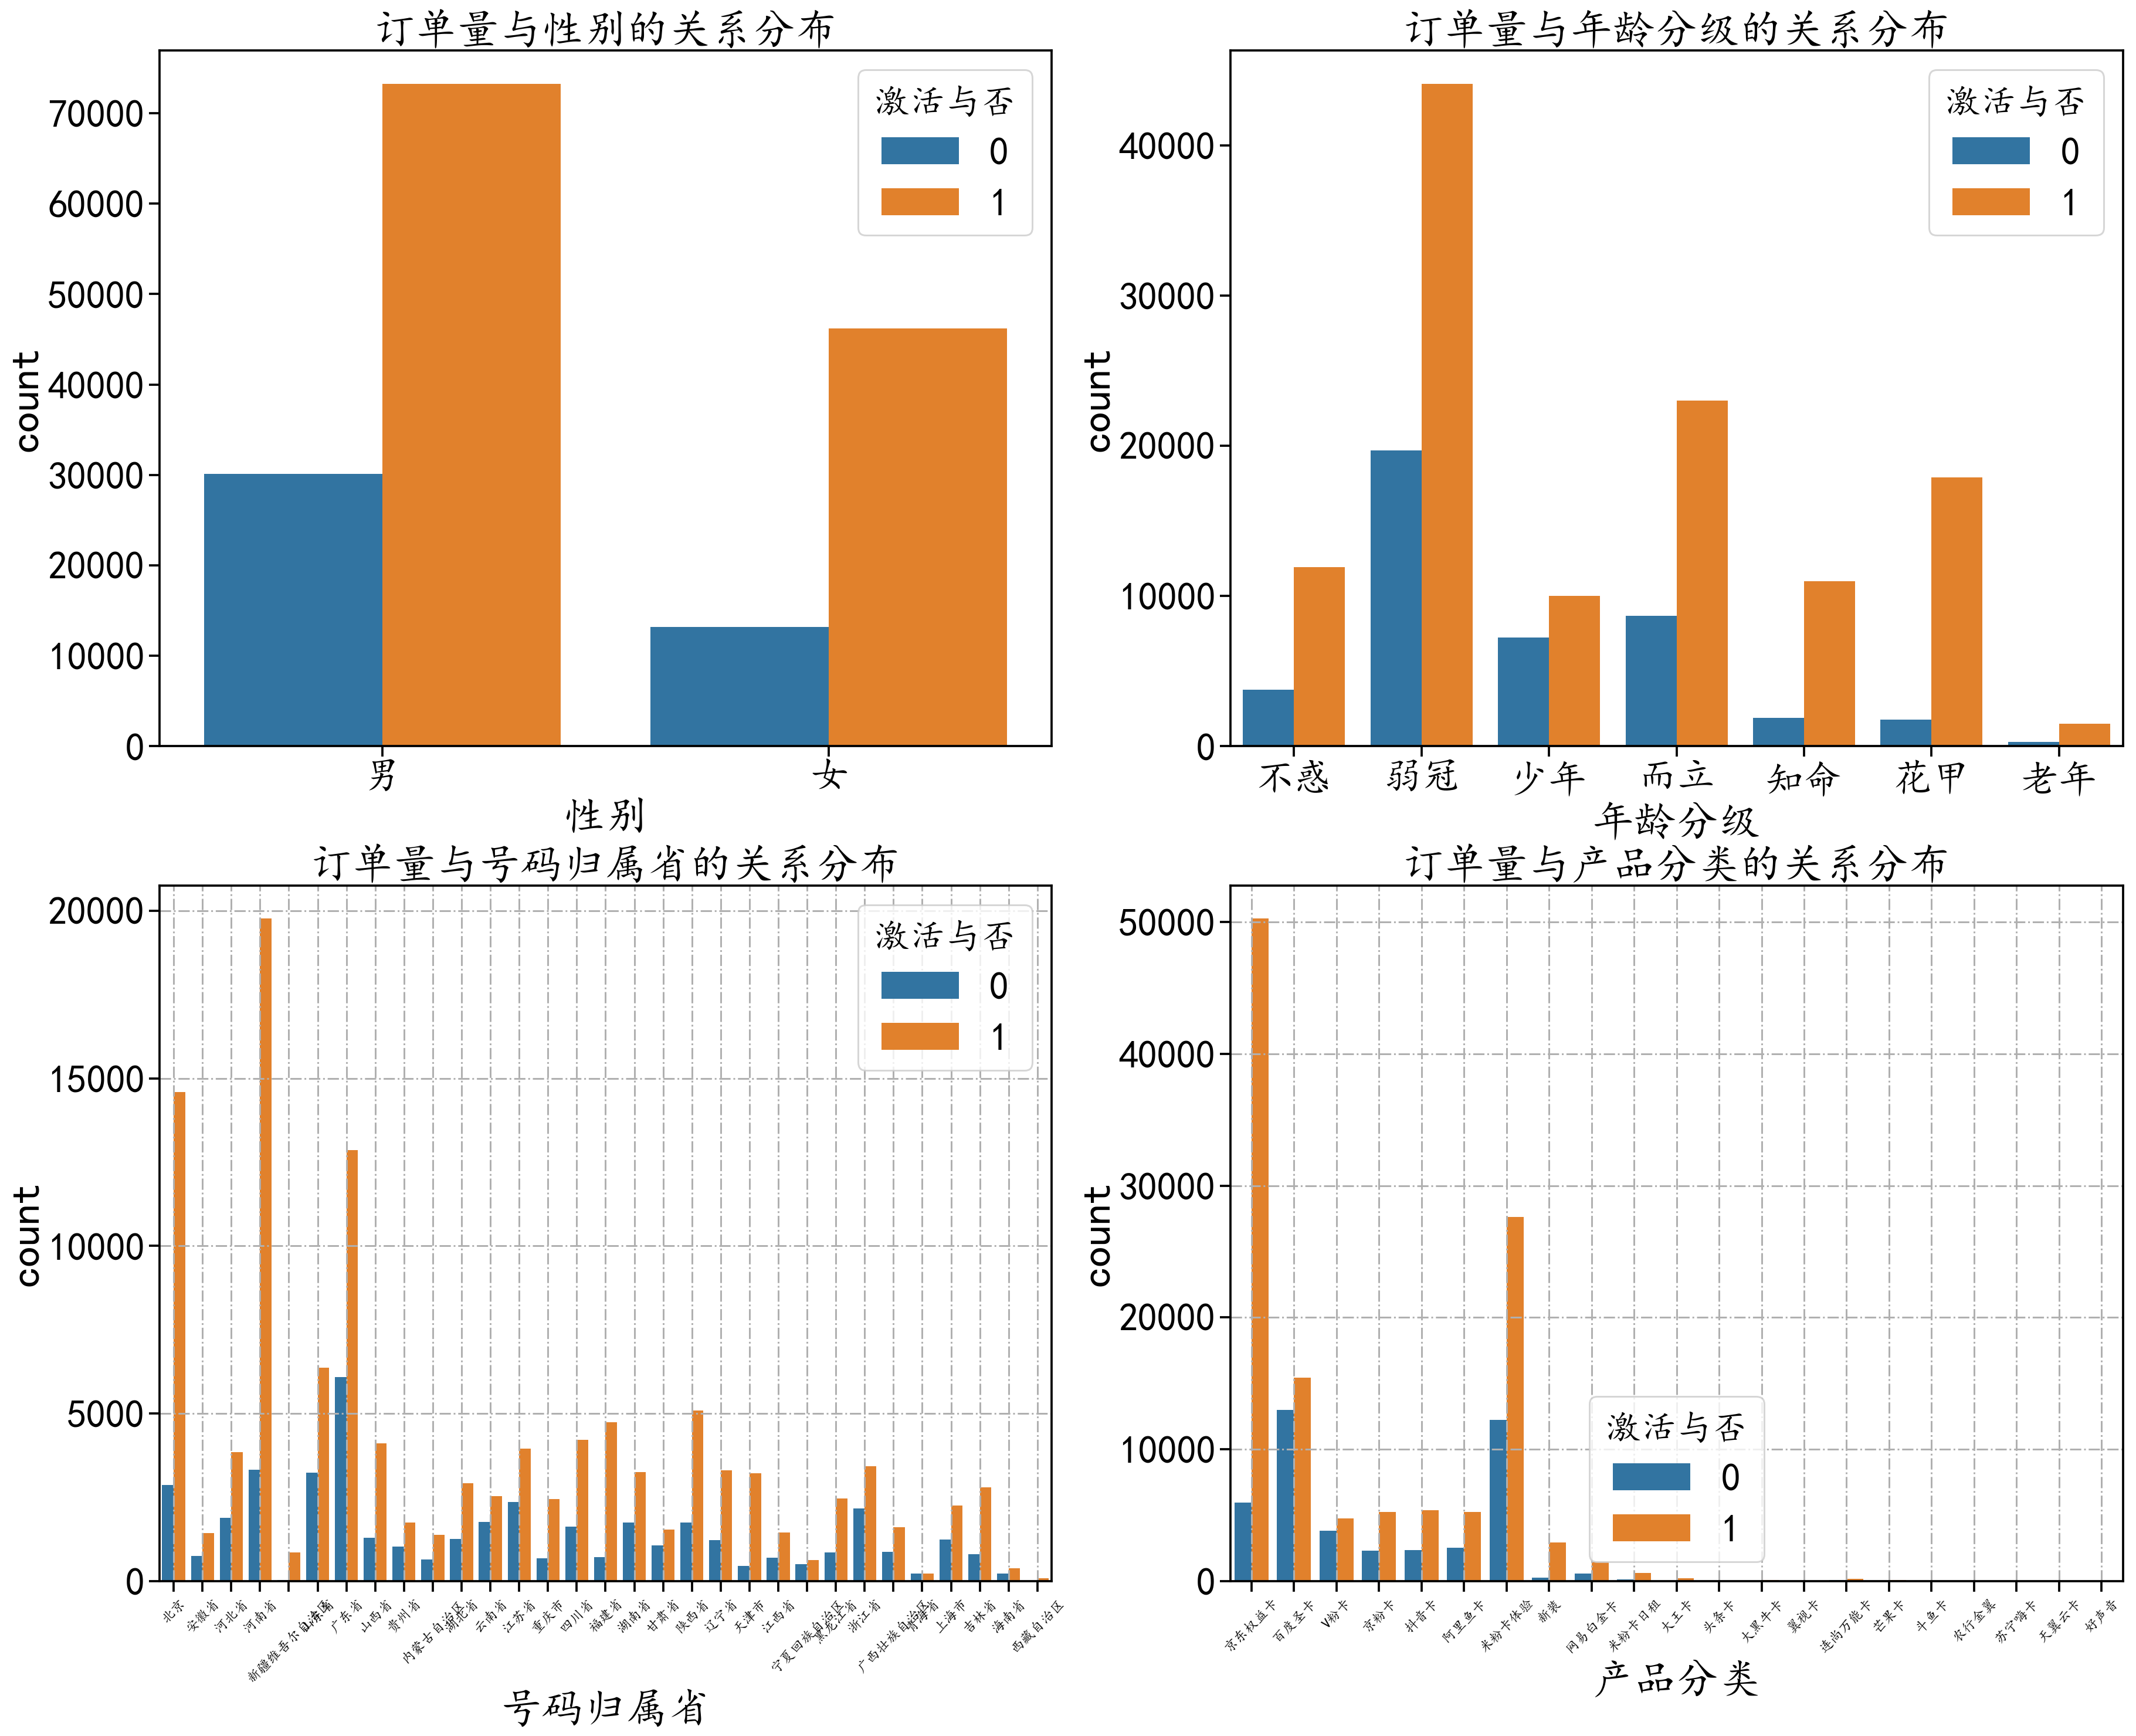

In [22]:
f,ax=plt.subplots(2,2,figsize=(30,24))  #设置图幅的大小和数量
sns.countplot('性别',data=sf_df_fahuo,ax=ax[0,0],hue='激活与否')  #绘制性别的统计图
sns.countplot('年龄分级',data=sf_df_fahuo,ax=ax[0,1],hue='激活与否')  #绘制“年龄级别”的统计图
sns.countplot('号码归属省',data=sf_df_fahuo,ax=ax[1,0],hue="激活与否") #绘制“号码归属省”的统计图
sns.countplot('产品分类',data=sf_df_fahuo,ax=ax[1,1],hue='激活与否')
ax[0,0].set_title("订单量与性别的关系分布")   #标题设置
ax[0,1].set_title("订单量与年龄分级的关系分布")
ax[1,0].set_title("订单量与号码归属省的关系分布")
ax[1,1].set_title("订单量与产品分类的关系分布")
# ax[1,0].set_xticklabels(ax.get_xticklabels(),rotation=-45)
# ax[0,1].set_xlabel('年龄分级',fontsize=12,color='r')   #设置X轴标签的“名称”、字体大小和字体颜色
# ax[0,1].set_ylabel('订单量',fontsize=12,color='r')    #设置Y轴标签的“名称”、字体大小和字体颜色
#设置网格样式
ax[1,0].grid(True, linestyle='-.')
for label in ax[1,0].xaxis.get_ticklabels():
#     label.set_color('red')   #设置x轴刻度的字体的旋转方向
    label.set_rotation(45)
    label.set_fontsize(12)
#     label.set_visible(False)   # x轴标签过于密集的解决方法,根据实际情况隐藏一些点,set_visible(False)是不显示，为True是显示
    label.set_visible(True)
ax[1,1].grid(True,linestyle='-.')

for label in ax[1,1].get_xticklabels():
    label.set_rotation(45)
    label.set_fontsize(12)
    label.set_visible(False)
for label in ax[1,1].xaxis.get_ticklabels()[::1]:     # x轴标签过于密集的解决方法,根据实际情况隐藏一些点,[::2]表示间隔2个显示
    label.set_visible(True)

In [23]:
#单幅图的绘制
# f,ax=plt.subplots(1,1,figsize=(50,30))  #设置图幅的大小和数量
# sns.countplot('号码归属省',data=sf_df,hue="性别")
# ax.set_title("订单量与号码归属省的关系分布")
# # import matplotlib.ticker as ticker
# for label in ax.xaxis.get_ticklabels():
#     label.set_rotation(45)
#     label.set_fontsize(20)
    
# ax.set_xlabel('号码归属省',fontsize=20,color='r')   #设置X轴标签的“名称”、字体大小和字体颜色
# ax.set_ylabel('订单量',fontsize=20,color='r')    #设置Y轴标签的“名称”、字体大小和字体颜色

In [24]:
#分析“产品分类”与“年龄分级”的关系
sf_df_fahuo.groupby(['产品分类','年龄分级'])['年龄分级'].count()

产品分类   年龄分级
V粉卡    不惑        762
       少年       2015
       弱冠       3766
       知命        413
       老年         58
       而立       1374
       花甲        195
京东权益卡  不惑       6496
       少年       1996
       弱冠      12444
       知命       7471
       老年       1306
       而立       9164
       花甲      17346
京粉卡    不惑        621
       少年        372
       弱冠       4203
       知命         65
       老年          8
       而立       2239
       花甲          9
农行金翼   不惑          3
       少年          1
       弱冠          1
       知命          2
       而立          3
大王卡    不惑         12
       少年         31
       弱冠        160
       知命          4
       老年          2
       而立         32
       花甲          1
大黑牛卡   不惑         10
       少年         17
       弱冠         53
       知命          4
       而立         13
       花甲          2
天翼云卡   而立          1
头条卡    少年          2
       弱冠          4
       知命          1
       而立          3
好声音    知命          1
抖音卡    不惑        744
       少年       1266
 

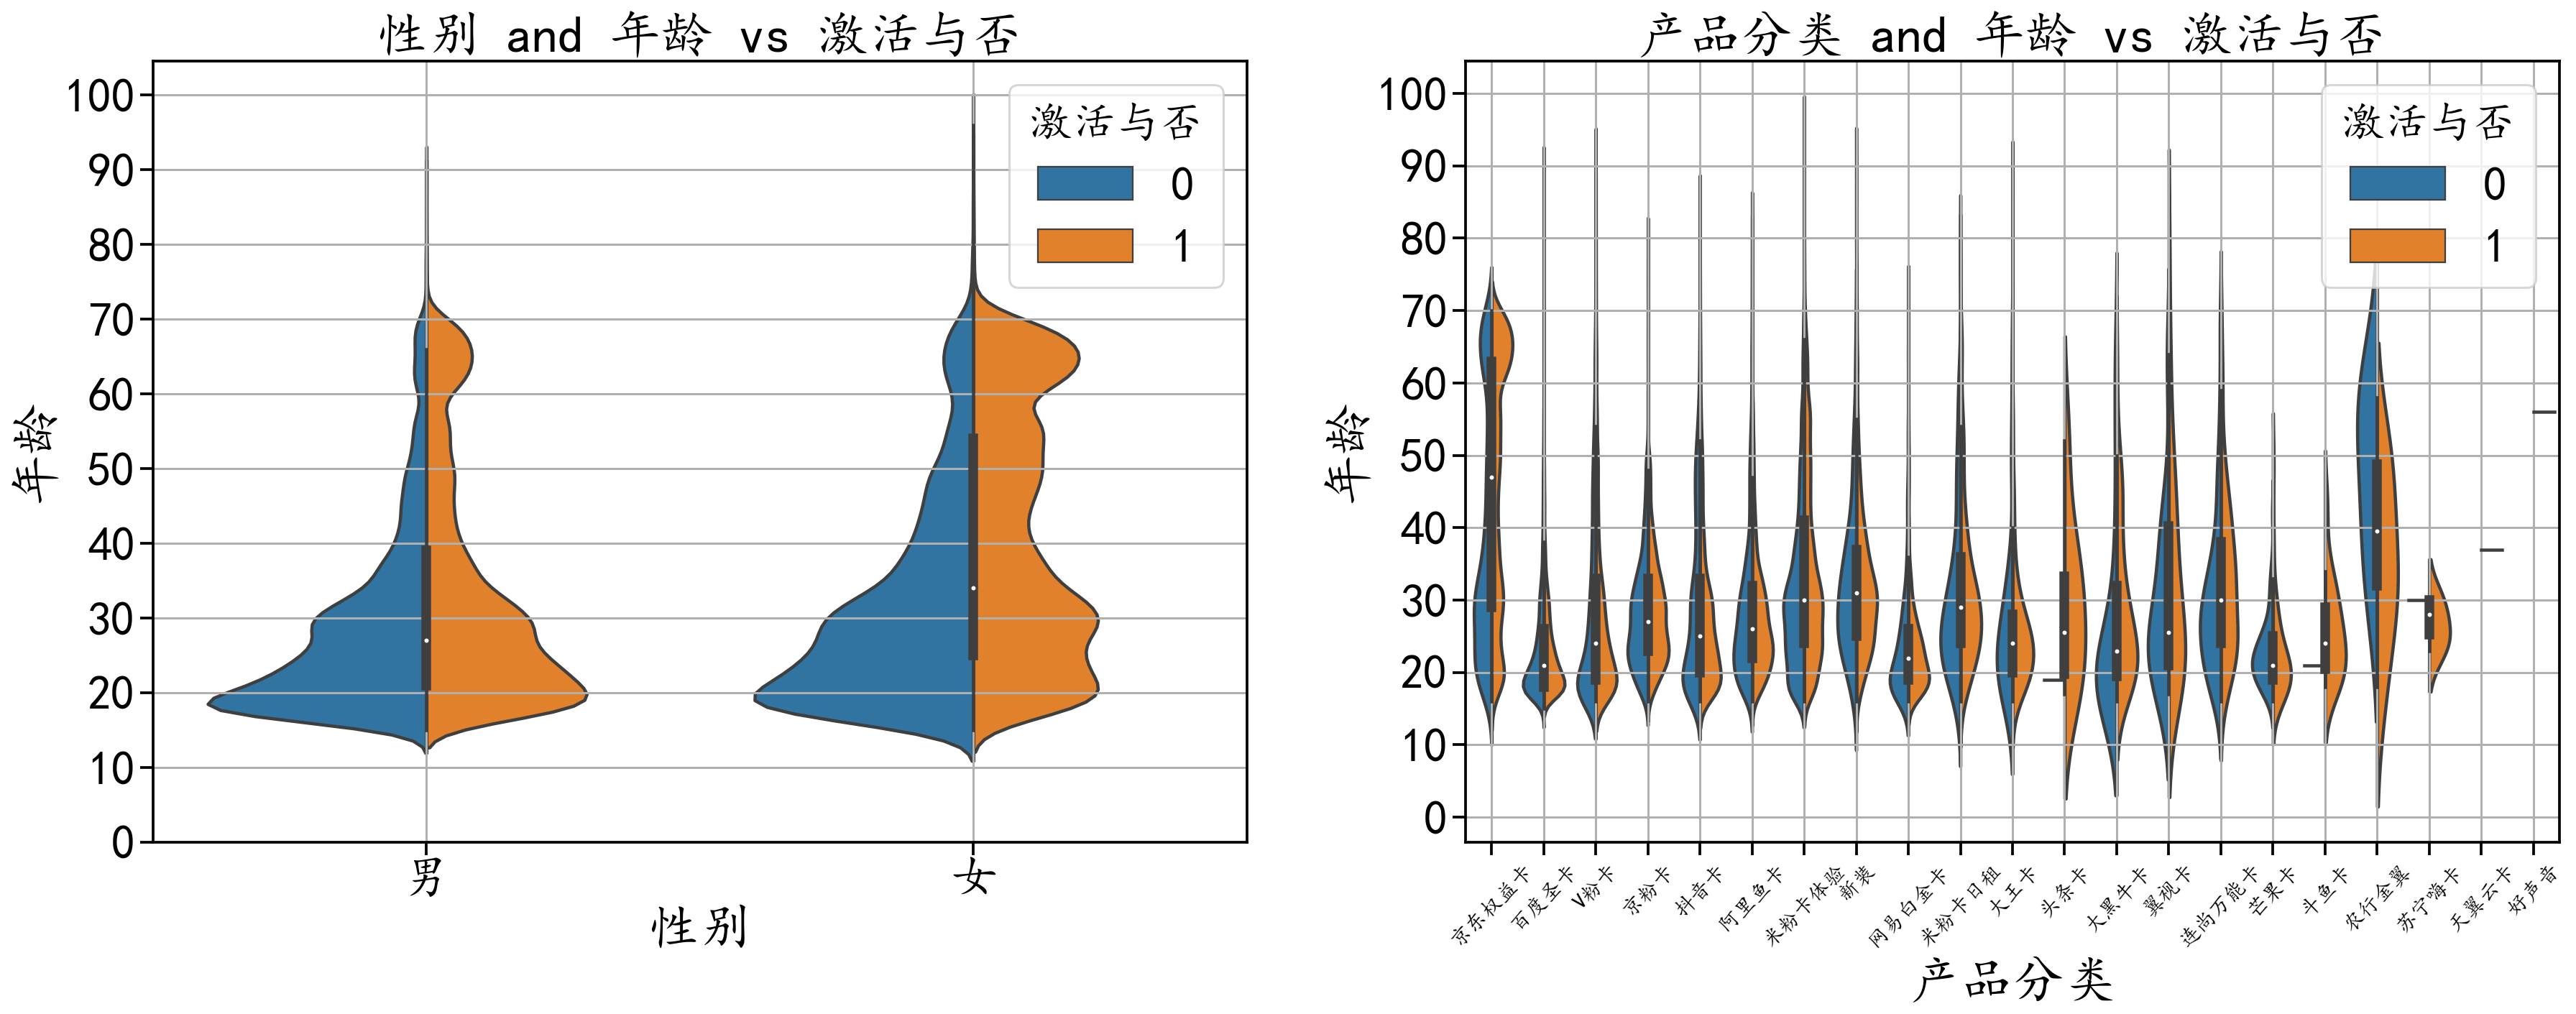

In [25]:
#"产品分类"与“年龄”的分布关系
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
sns.violinplot("性别", "年龄", hue="激活与否", data=sf_df_fahuo, split=True, ax=ax[0])
ax[0].set_title('性别 and 年龄 vs 激活与否')
ax[0].set_yticks(range(0, 110, 10))
ax[0].grid(True, linestyle='-')

sns.violinplot("产品分类","年龄",hue="激活与否",data=sf_df_fahuo, split=True, ax=ax[1])
ax[1].set_title("产品分类 and 年龄 vs 激活与否" )
ax[1].set_yticks(range(0,110,10))
ax[1].grid(True,linestyle='-')
for label in ax[1].get_xticklabels():
    label.set_rotation(45)
    label.set_fontsize(15)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

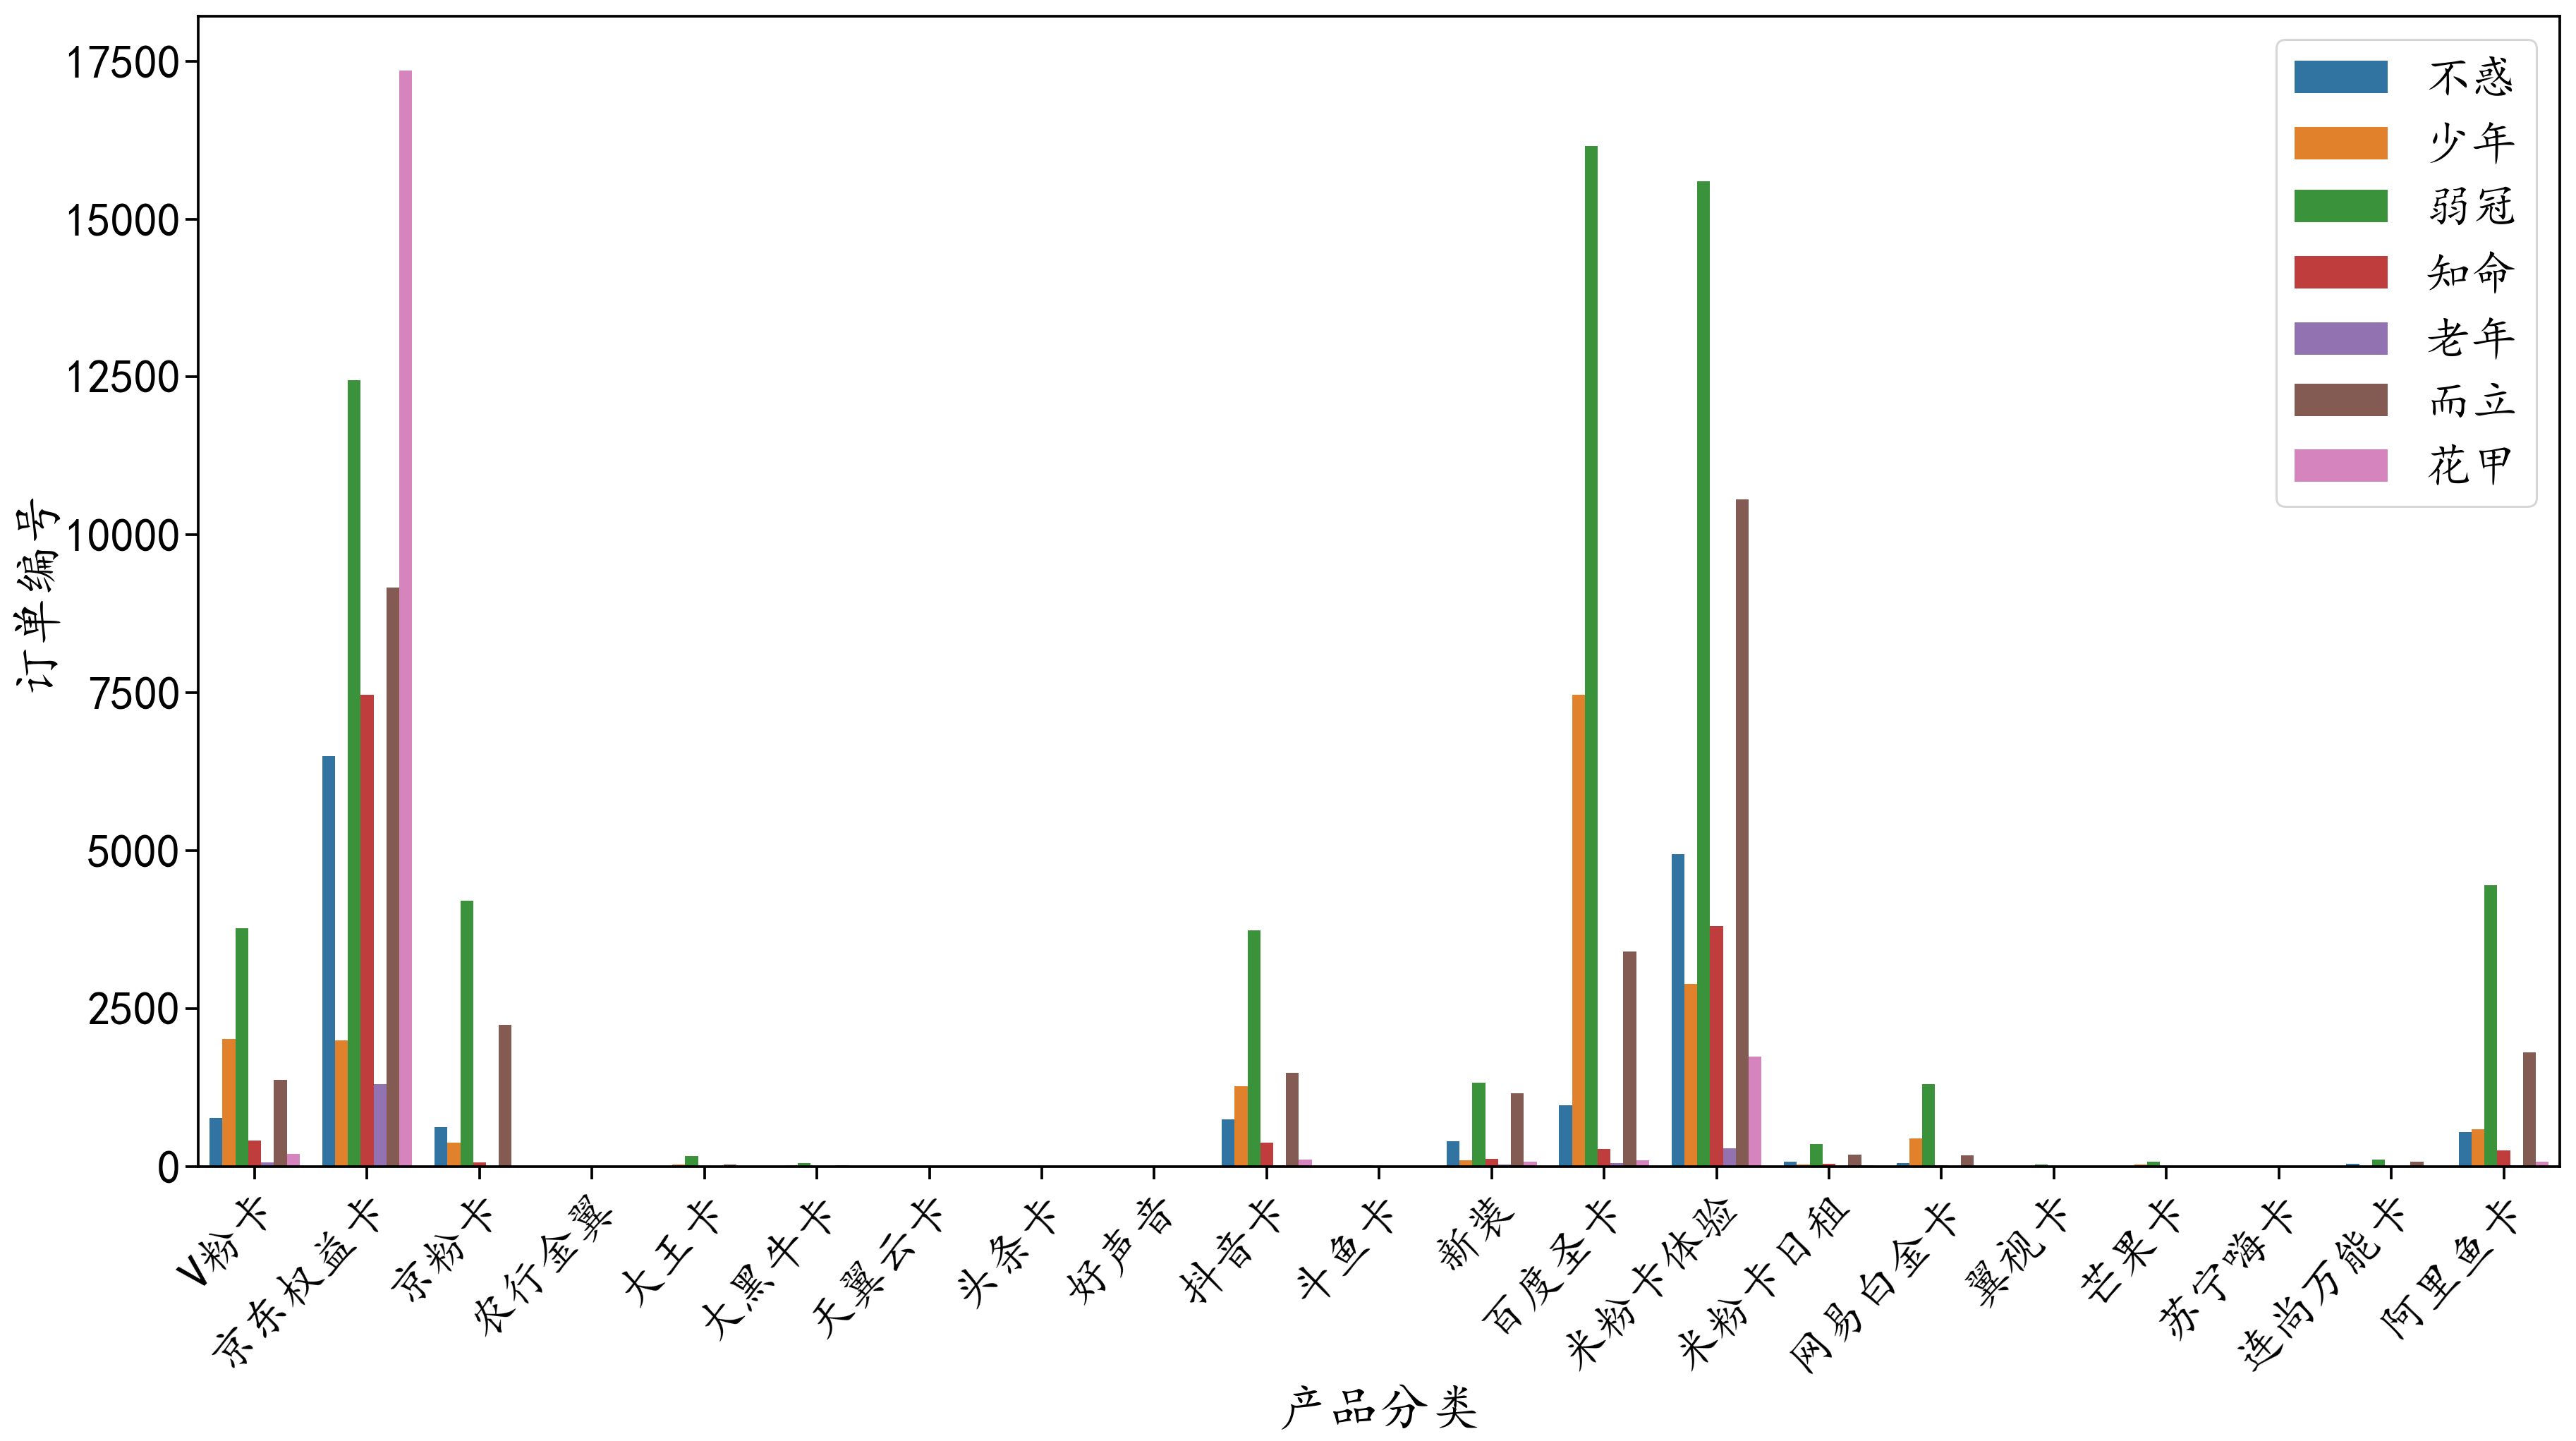

In [26]:
#参数as_index=False，将索引列转为“普通列”
# sf_df_fahuo[['产品分类','年龄分级']].groupby(['年龄分级'],as_index=False).count()
# ax.set_title("产品分类与年龄分级的分布关系")
cp_nj=sf_df_fahuo[['产品分类','年龄分级','订单编号']].groupby(['产品分类','年龄分级'],as_index=False).count()
# sf_df_fahuo.groupby(['产品分类','年龄分级'])['年龄分级'].count()
f,ax=plt.subplots(1,1,figsize=(30,15))  #设置图幅的大小和数量
sns.barplot(x='产品分类', y='订单编号', hue="年龄分级",data=cp_nj,ci=0)
plt.legend(loc = 'upper right')  #设置图例放置的位置为右上角
# ax.set_xlabel("va=top")   #设置X轴的标签 
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") #旋转刻度标签并设置其对齐方式
#或者
# plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
#          ha="right", va="center", rotation_mode="anchor")  
# ha='center', va= 'bottom'代表horizontalalignment（水平对齐）、verticalalignment（垂直对齐）的方式，
#ha有三个选择：right,center,left,va有四个选择：'top', 'bottom', 'center', 'baseline'
# tick.label1 表示第一个图的label设置，若改为tick.label2则会报错。

In [27]:
#part 02 变量的转换
#变量转换的目的是将数据转换为适用于模型使用的数据，不同模型接受不同类型的数据。
#Scikit-learn要求数据都是数字型numeric，所以我们要将一些非数字型的原始数据转换为数字型numeric。
#定性(Qualitative)转换：此时qualitative variable是一些频繁出现的几个独立变量时，Dummy Variables比较适合使用
sf_df_last=sf_df_fahuo[['订单编号','性别','年龄','年龄分级','产品分类','号码归属省','交易周期','激活与否']]
sf_df_last.tail()

,订单编号,性别,年龄,年龄分级,产品分类,号码归属省,交易周期,激活与否
162751,690000000001008319051324127595,男,36,而立,米粉卡体验,浙江省,nan,0
162752,600103832000008319051306101865,女,82,老年,阿里鱼卡,江苏省,80.97,1
162753,690000000001008319051324127594,女,37,而立,京东权益卡,福建省,0.10,1
162754,690000000001008319051324127626,女,35,而立,米粉卡体验,广东省,27.93,1
162755,690000000001008319051324127605,男,23,弱冠,米粉卡体验,广东省,9.65,1


In [28]:
print(sf_df_last['年龄分级'].nunique())
print(sf_df_last['产品分类'].nunique())  #统计“产品分类”类不重复项的个数
print(sf_df_last['号码归属省'].nunique())

7
21
31


In [29]:
#定性变量（离散型变量）离散化——采用factorize进行离散化为numeric型数值
#方法一：使用factoriz进行编码
sf_df_last['性别']=pd.factorize(sf_df_last['性别'])[0]
#方法二：使用dummies进行编码
# sex_dummies_df=pd.get_dummies(sf_df_last['性别'],prefix=sf_df_last[['性别']].columns[0])
# sf_df_last=pd.concat([sf_df_last,sex_dummies_df],axis=1)
sf_df_last['年龄分级']=pd.factorize(sf_df_last['年龄分级'])[0]
sf_df_last['号码归属省']=pd.factorize(sf_df_last['号码归属省'])[0]
sf_df_last['产品分类']=pd.factorize(sf_df_last['产品分类'])[0]
#通过"Binning"将连续数据离散化。存储的值被分布到一些“桶”或“箱“”中，就像直方图的bin将数据划分成几块一样。
#下面的代码对'交易周期'进行Binning。
sf_df_last['交易周期'][sf_df_last['交易周期'].isnull()]=1000  #将“交易周期”列的空缺项，填充为“1000”
#将“交易周期”映射为一天为单位的离散区间量，从0.5天开始，依次为1.5天、2.5天,...直至9.5天以上的直接归为10天
#binning之后方便之后进行factorize,即：特征离散化
def func_period(str1):
    if str1<=12:
        return 0.5
    elif str1<=36:
        return 1.5
    elif str1<=60:
        return 2.5
    elif str1<=84:
        return 3.5
    elif str1<=108:
        return 4.5
    elif str1<=132:
        return 5.5
    elif str1<=156:
        return 6.5
    elif str1<=180:
        return 7.5
    elif str1<=204:
        return 8.5
    elif str1<=228:
        return 9.5
    else:
        return 10
  
sf_df_last['交易周期']=sf_df_last['交易周期'].apply(func_period)   
sf_df_last['交易周期']=pd.factorize(sf_df_last['交易周期'])[0]  #使用factorize进行特征离散

c:\users\evan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\evan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\evan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [30]:
sf_df_last.tail()

,订单编号,性别,年龄,年龄分级,产品分类,号码归属省,交易周期,激活与否
162751,690000000001008319051324127595,0,36,3,6,24,2,0
162752,600103832000008319051306101865,1,82,6,5,12,5,1
162753,690000000001008319051324127594,1,37,3,0,15,0,1
162754,690000000001008319051324127626,1,35,3,6,6,3,1
162755,690000000001008319051324127605,0,23,1,6,6,0,1


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text xticklabel objects>)

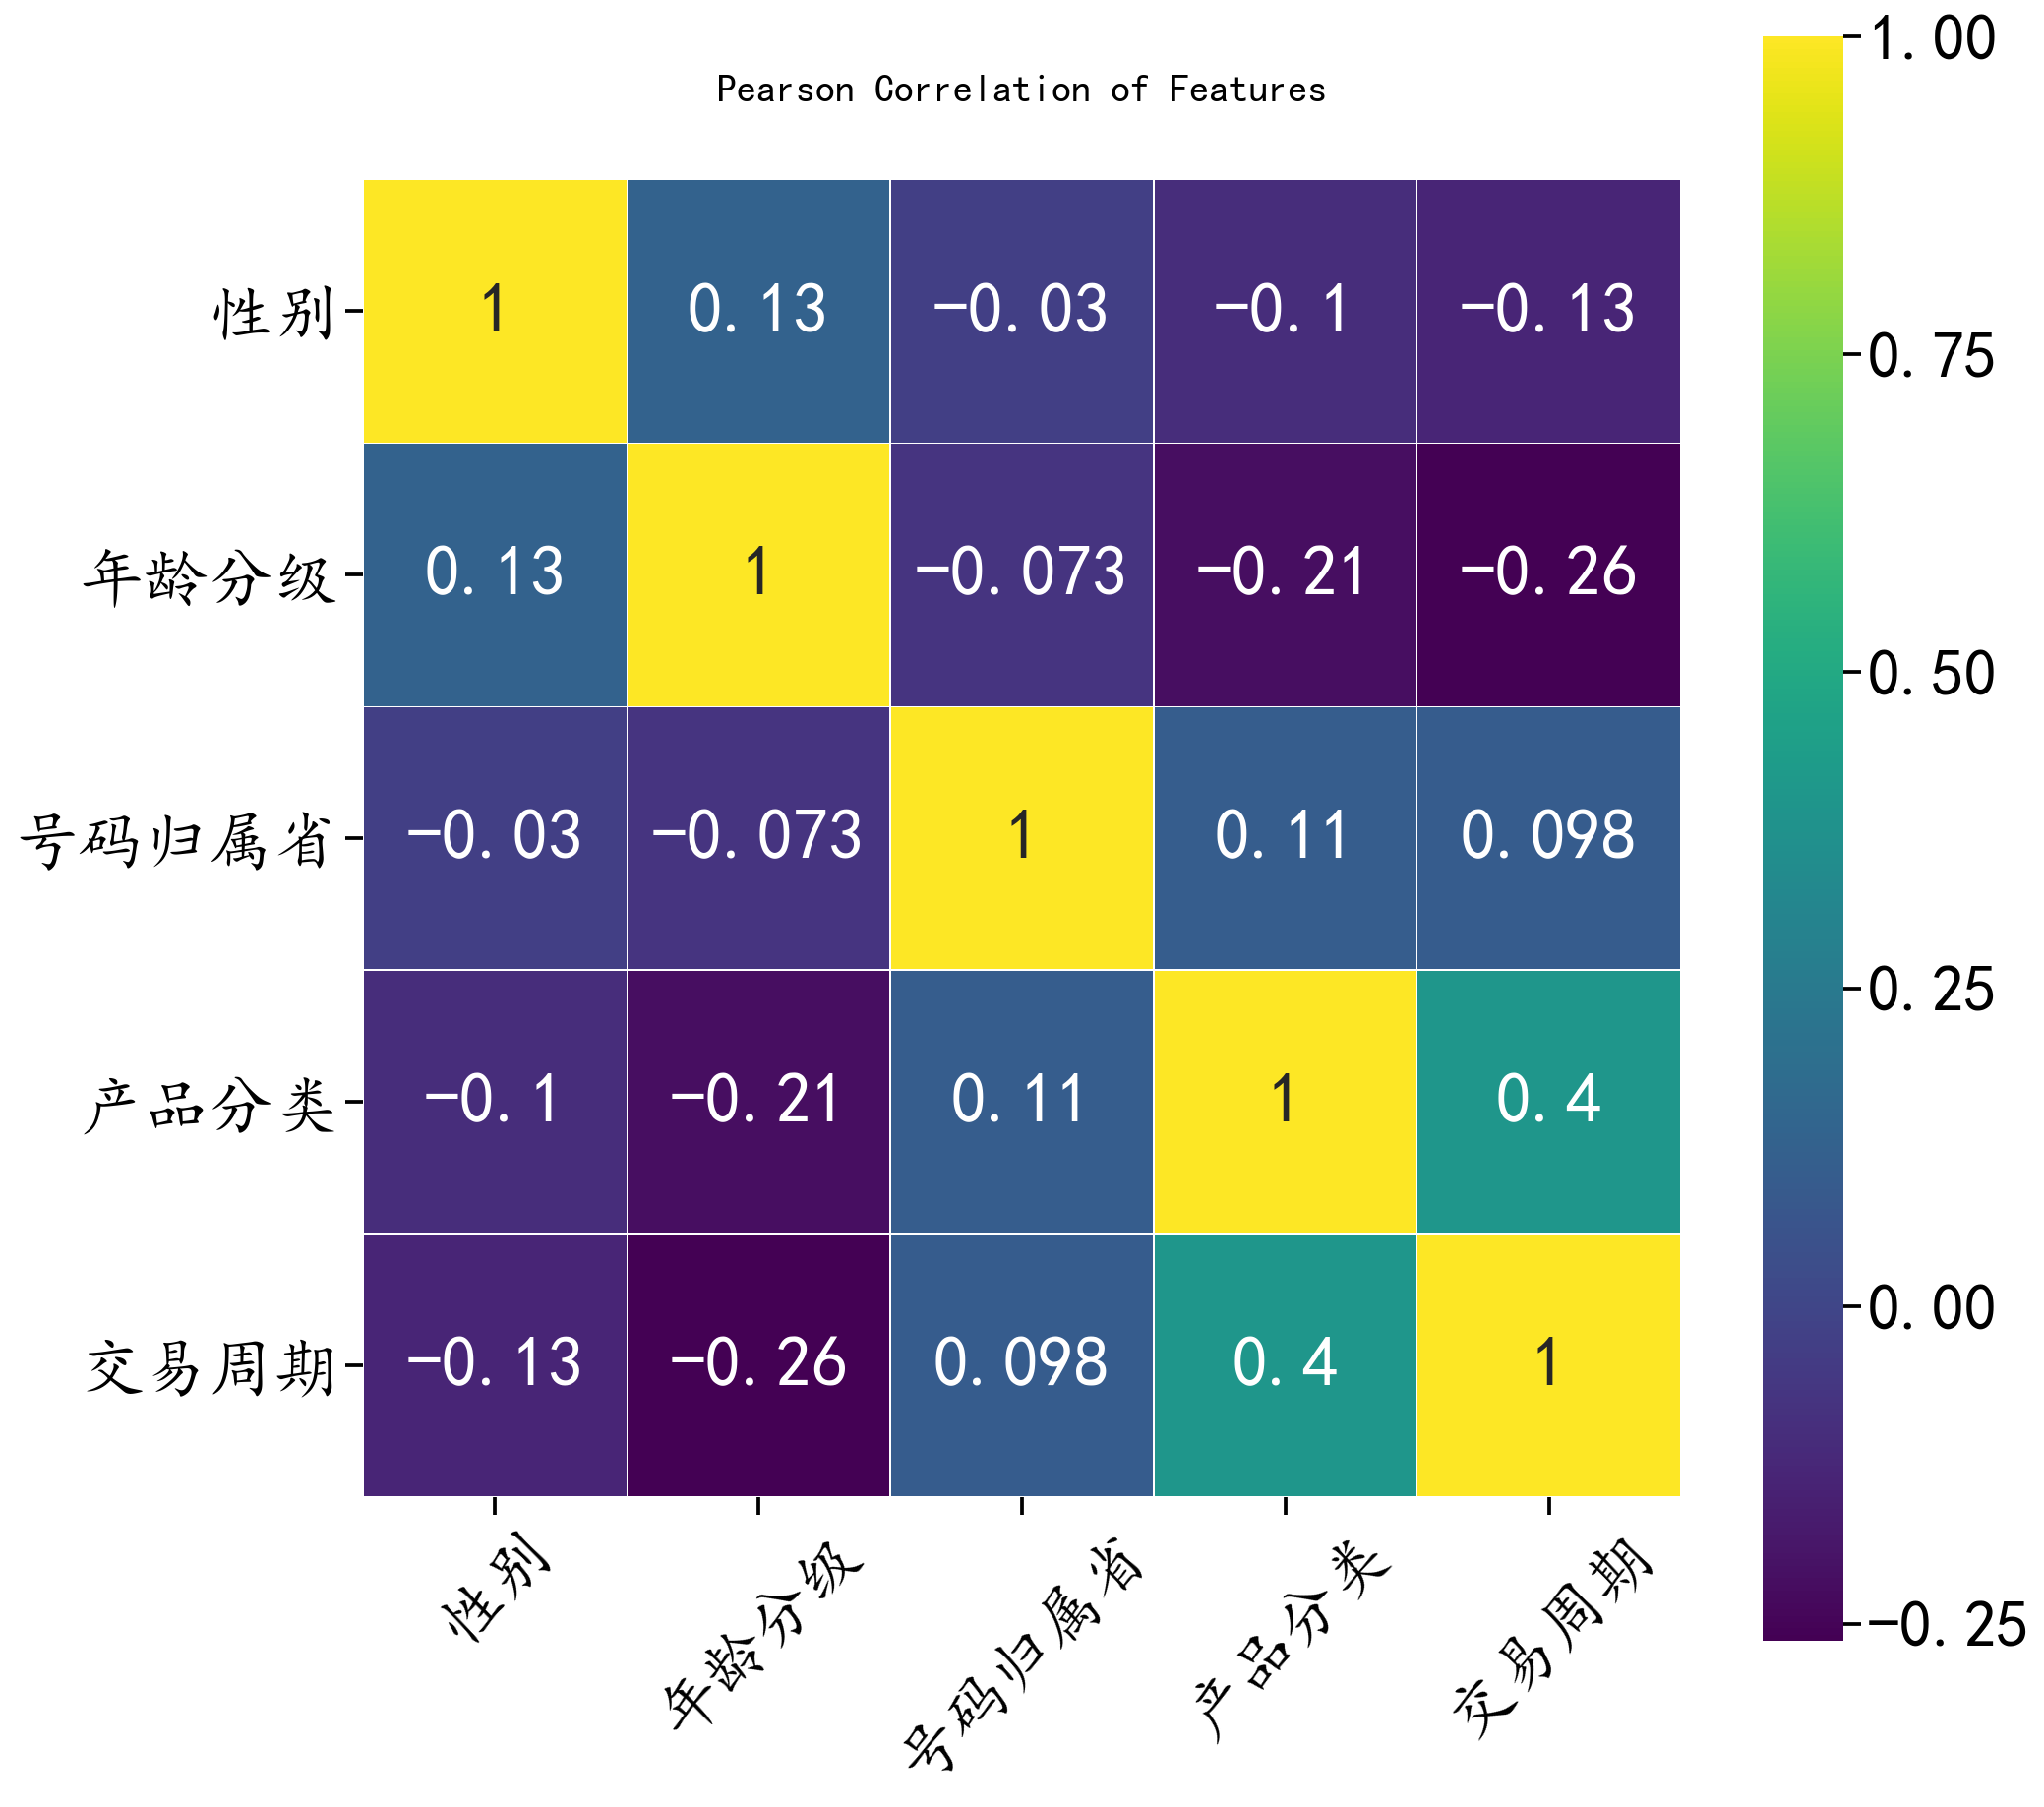

In [31]:
#描述相关性
#一般的，描述相关性一般使用 pairplot 图和 heatmap 图
#heatmap 图
Correlation=sf_df_last[['性别','年龄分级','号码归属省','产品分类','交易周期']]

colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.xticks(rotation=45)    # 将字体进行旋转(seaborn和matplotlib模式下X轴旋转的方式不同)

In [ ]:
sf_df_last.tail()

In [ ]:
#pairplot 图
sns.set(style='ticks')
pairplot_df=sf_df_last[['激活与否','性别','年龄分级','号码归属省','产品分类','交易周期']]
g=sns.pairplot(pairplot_df,hue='激活与否',palette = 'seismic',size=1.2,
               diag_kind = 'hist',diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

In [32]:
#将训练数据分成标记和特征两部分
labels=sf_df_last['激活与否']
features=sf_df_last[['性别','年龄分级','号码归属省','产品分类','交易周期']]

In [33]:
#part 03模型训练
#首先引入需要的库和函数
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,roc_auc_score
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier

In [34]:
#定义通用函数框架
def fit_model(alg,parameters):
    X=features
    y=labels #由于数据较少，使用全部数据进行网格搜索
    scorer=make_scorer(roc_auc_score)   #使用roc_auc_score作为评分标准
    grid=GridSearchCV(alg,parameters,scoring=scorer,cv=5)  #使用网格搜索，出入参数
    start=time()  #计时
    grid=grid.fit(X,y)  #模型训练
    end=time()
    t=round(end-start,3)
    print(grid.best_params_)  #输出最佳参数
    print("searching time for {} is {}s".format(alg.__class__.__name__,t))  #输出搜索时间
    return grid  #返回训练好的模型

In [35]:
#定义初始函数
#列出需要使用的算法
alg1=DecisionTreeClassifier(random_state=29)
alg2=SVC(probability=True,random_state=29)  #由于使用roc_auc_score作为评分标准，需将SVC中的probability参数设置为True
alg3=RandomForestClassifier(random_state=29)
alg4=AdaBoostClassifier(random_state=29)
alg5=KNeighborsClassifier(n_jobs=-1)
alg6=XGBClassifier(random_state=29,n_jobs=-1)

In [36]:
#列出我们需要调整的参数及取值范围，这是一个很繁琐的工作，需要大量的尝试和优化。
parameters1={'max_depth':range(1,10),"min_samples_split":range(2,10)}  # best param {'max_depth': 2, 'min_samples_split': 2}
parameters2={'C':range(1,20),'gamma':[0.05,0.1,0.15,0.2,0.25]}
parameters3_1={'n_estimators':range(10,200,10)}   # best param {'n_estimators': 10},{'max_depth': 7, 'min_samples_split': 3}
parameters3_2={'max_depth':range(1,10),'min_samples_split':range(2,10)} #搜索空间太大，分两次调整参数
parameters4={'n_estimators':range(10,200,10),'learning_rate':[i/10.0 for i in range(5,15)]}
parameters5={'n_estimators':range(2,10),'leaf_size':range(10,80,20)}
parameters6_1={'n_estimators':range(10,200,10)}  # best param {'n_estimators': 10}
parameters6_2={'max_depth':range(1,10),'min_child_weight':range(1,10)}  # best param {'max_depth': 2, 'min_child_weight': 1}
parameters6_3={'subsample':[i/10.0 for i in range(1,10)],
               'colsample_bytree':[i/10.0 for i in range(1,10)]}  # best param {'colsample_bytree': 0.1, 'subsample': 0.3}
#搜索空间太大，分三次调整参数

In [ ]:
#开始调整参数
#DecisionTreeClassifier
clf1=fit_model(alg1,parameters1)

In [ ]:
#SVM
clf2=fit_model(alg2,parameters2)

In [ ]:
#RandomForest
#第一次调参
clf3_m1=fit_model(alg3,parameters3_1)

In [ ]:
#第二次调参数
alg3=RandomForestClassifier(random_state=29,n_estimators=10)
clf3=fit_model(alg3,parameters3_2)

In [ ]:
#AdaBoost
clf4=fit_model(alg4,parameters4)

In [43]:
#KNN
clf5=fit_model(alg5,parameters5)

ValueError: Invalid parameter n_estimators for estimator KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'). Check the list of available parameters with `estimator.get_params().keys()`.

In [38]:
#Xgboost
#第一次调参
clf6_m1=fit_model(alg6,parameters6_1)

{'n_estimators': 10}
searching time for XGBClassifier is 284.238s


In [39]:
#第二次调参
alg6=XGBClassifier(n_estimators=10,random_state=29,n_jobs=-1)
clf6_m2=fit_model(alg6,parameters6_2)

{'max_depth': 2, 'min_child_weight': 1}
searching time for XGBClassifier is 267.478s


In [40]:
#第三次调参
alg6=XGBClassifier(n_estimators=140,max_depth=2,min_child_weight=1,random_state=29,n_jobs=-1)
clf6=fit_model(alg6,parameters6_3)

{'colsample_bytree': 0.1, 'subsample': 0.3}
searching time for XGBClassifier is 1938.126s


In [41]:
#至此调参和训练过程结束，我们已经训练得到了6个模型，现在是检验成果的时候了
#首先定义一个保存函数，将预测的结果保存为可以提交的格式
# def save(clf,i):
#     pred=clf.predict(test)
#     sub=pd.DataFrame({'订单编号':,'激活与否':})
#     sub.to_csv('res_tan_{}.csv'.format(i),index=False)

In [42]:
#调用这个函数，完成6个模型的预测：
# i=1
# for clf in [clf1,clf2,clf3,clf4,clf5,clf6]:
#     save(clf,i)
#     i=i+1